In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve,auc,accuracy_score,confusion_matrix
from sklearn.metrics import classification_report,f1_score, confusion_matrix,accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [6]:
def data_prepare(dataset):
    """Transfrom some dataset columns as dummies and remove irrelevant columns for the model training.

    Args:
        dataset (pandas.DataFrame): Dataframe with the data 

    Returns:
        pandas.DataFrame: Dataframe with the data and columns modified
    """
    dataset = dataset.drop(['id', 'CustomerId', 'Surname'], axis=1)
    categorical_cols = ['Geography', 'Gender']
    drop_first = True
    df_dummies = pd.get_dummies(dataset, columns=categorical_cols, dtype='int')
    return df_dummies


GENERAL_PATH = os.curdir
inference_path = os.path.join(GENERAL_PATH, 'inference.csv')
train_path = os.path.join(GENERAL_PATH, 'train.csv')
inference = pd.read_csv(inference_path)
train = pd.read_csv(train_path)

df_dummies = data_prepare(train)
# Remove columns with no information
train.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)
train.info()

# Column creation for exploratory analisis
train['Churn_label'] = train['Churn'].apply(lambda x: 'Yes' if x == 1 else 'No')

bins = [0, 50000, 75000, 100000, float('inf')]
labels = ['<50K', '50K - 75K', '75 K - 100 K', '>100 K']
train['Salary_ranges'] = pd.cut(train['EstimatedSalary'], bins=bins, labels=labels, right=False)


bins = [0, 20, 40, 60, float('inf')]
labels = ['<20', '20 - 40', '40 - 60', '>60']
train['Age_ranges'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148531 entries, 0 to 148530
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      148531 non-null  int64  
 1   Geography        148531 non-null  object 
 2   Gender           148531 non-null  object 
 3   Age              148531 non-null  float64
 4   Tenure           148531 non-null  int64  
 5   Balance          148531 non-null  float64
 6   NumOfProducts    148531 non-null  int64  
 7   HasCrCard        148531 non-null  float64
 8   IsActiveMember   148531 non-null  float64
 9   EstimatedSalary  148531 non-null  float64
 10  Churn            148531 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 12.5+ MB


<Axes: >

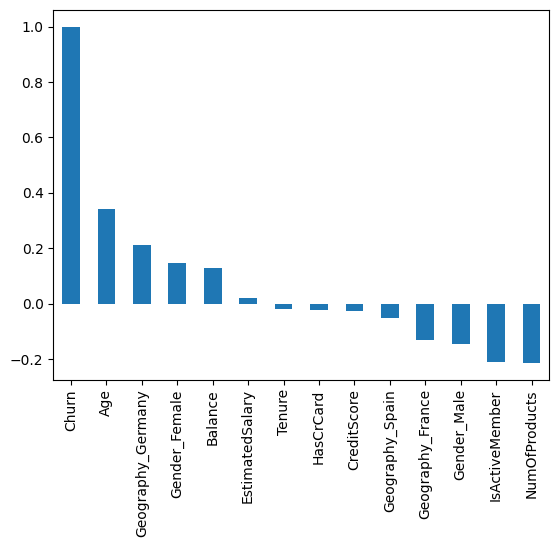

In [7]:
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

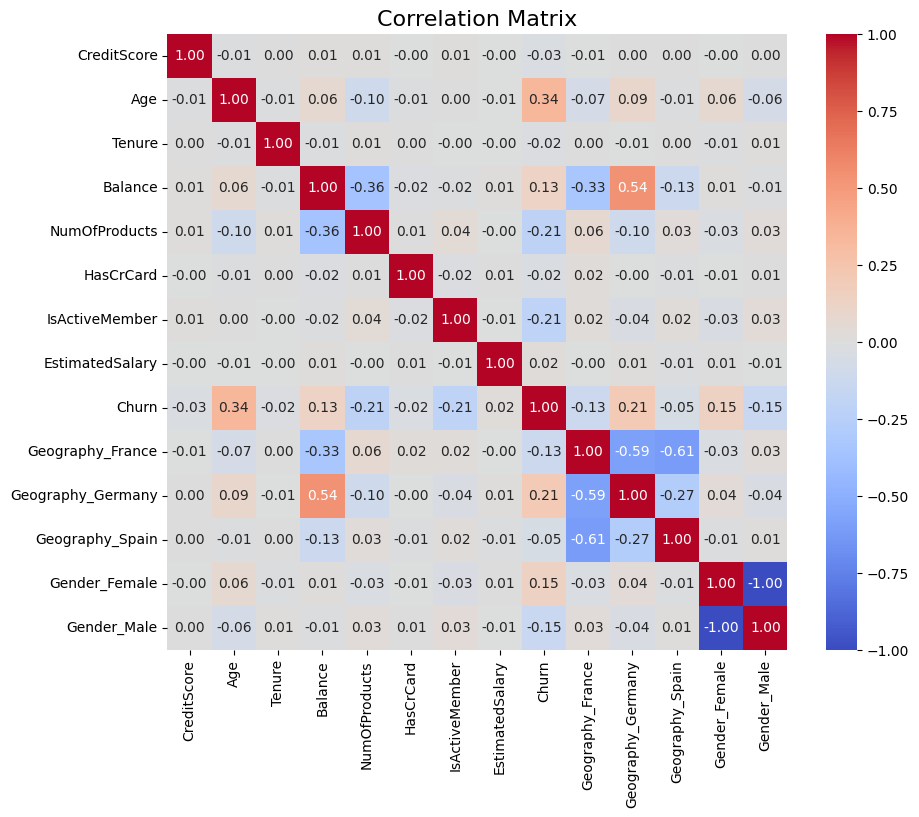

In [8]:
corr_matrix = df_dummies.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, center=0)

plt.title('Correlation Matrix', fontsize=16)
plt.show()

When looking at the correlation plot and matrix, we can notice that Age, being from Germany, being a female and having a high balance have a positive correlation. Meanwhile, being a member or having products have a negative correlation.

In [9]:
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn,Churn_label,Salary_ranges,Age_ranges
0,619,Germany,Female,32.0,8,175406.13,1,1.0,0.0,172792.43,1,Yes,>100 K,20 - 40
1,676,Germany,Female,40.0,4,180520.41,2,1.0,1.0,171045.25,0,No,>100 K,40 - 60
2,748,France,Female,39.0,8,0.00,1,0.0,0.0,57323.18,1,Yes,50K - 75K,20 - 40
3,641,France,Female,39.0,4,0.00,1,1.0,0.0,45309.24,1,Yes,<50K,20 - 40
4,688,Germany,Male,42.0,9,161588.89,2,0.0,1.0,54019.93,0,No,50K - 75K,40 - 60


In [10]:
df_dummies.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,32.0,8,175406.13,1,1.0,0.0,172792.43,1,0,1,0,1,0
1,676,40.0,4,180520.41,2,1.0,1.0,171045.25,0,0,1,0,1,0
2,748,39.0,8,0.00,1,0.0,0.0,57323.18,1,1,0,0,1,0
3,641,39.0,4,0.00,1,1.0,0.0,45309.24,1,1,0,0,1,0
4,688,42.0,9,161588.89,2,0.0,1.0,54019.93,0,0,1,0,0,1


## DATA EXPLORATION

### Let's explore the distribution of all the variables to find patterns before introducing this to our models

### * ***Churn***

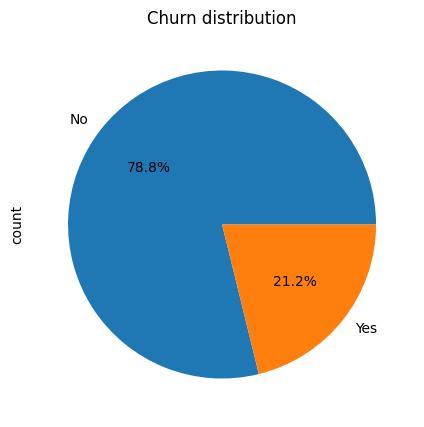

In [11]:
fig = plt.figure(figsize=(7, 5))

gs = fig.add_gridspec(1,1)
ax1 = fig.add_subplot(gs[0, 0])

train['Churn_label'].value_counts().plot.pie(autopct='%1.1f%%', ax = ax1)
ax1.set_title('Churn distribution')

plt.show()



### * ***Geography***: More than half of our database are french with a 57%, followed by people from spain with a 22% and lastly germans with 20.9%

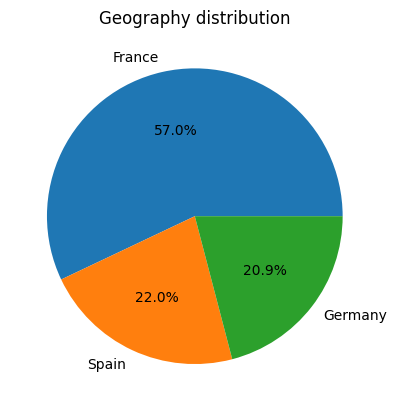

In [12]:
(train['Geography'].value_counts() * 100 / len(train)).plot.pie(autopct='%1.1f%%')
plt.title('Geography distribution')
plt.ylabel('')
plt.show()

### * ***Gender and Age***: In general the database is balanced in terms of **Gender**, were 56.5% of the subjects are male and the remaining 43.5% are female. For the case of **Age**, most of the subjects are less than 50 years old. Plots also shows the distribution of the genders for each location available.



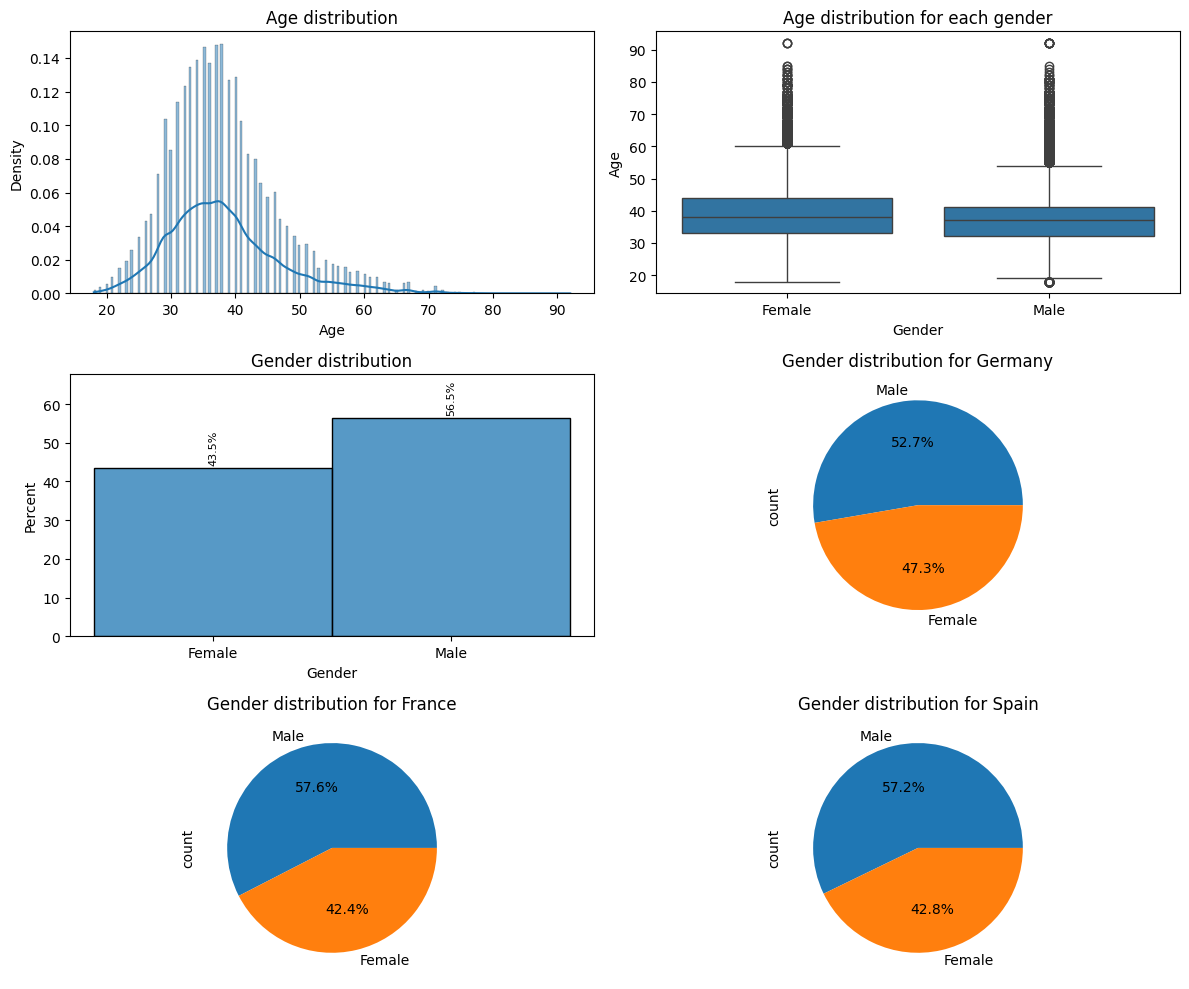

In [13]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])


sns.histplot(data=train, x='Age', ax=ax1, kde=True, stat = 'density')
ax1.set_title('Age distribution')

sns.boxplot(x="Gender", y="Age",
            data=train, ax=ax2)
ax2.set_title('Age distribution for each gender')

fg = sns.histplot(data=train, x='Gender', ax=ax3, stat = 'percent')



# add annotations
for c in fg.containers:

    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

    fg.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=90, padding=2)

fg.margins(y=0.2)

ax3.set_title('Gender distribution')

(train[train['Geography']=='Germany']['Gender'].value_counts() * 100 / len(train)).plot.pie(autopct='%1.1f%%', ax = ax4)
ax4.set_title('Gender distribution for Germany')

(train[train['Geography']=='France']['Gender'].value_counts() * 100 / len(train)).plot.pie(autopct='%1.1f%%', ax = ax5)
ax5.set_title('Gender distribution for France')

(train[train['Geography']=='Spain']['Gender'].value_counts() * 100 / len(train)).plot.pie(autopct='%1.1f%%', ax = ax6)
ax6.set_title('Gender distribution for Spain')

plt.tight_layout()
plt.show()

### For the analysis of customer churm, the estimated salary as well as the balance can be two main features.

### For this case, the balance feature is suppoused as the balance of the customer and also 0 is considered as a default value not as 0 value in the account. This is a bold supossition but having more information about this column can confirm or deny this hypotesis. This supposition comes from the fact that balance as a random variable will tend to have a normal distirbution based on the central limit theorem.

### When the whole database is selected, half of the sample has 0 as their balance, thats why more information about the Balance feature can be helpful to understand whether this is normal or is something that needs to be taken into account.


### * ***Balance and EstimatedSalary***: For the **Balance** feature we can see a normal distribution if the 0 values are removed. In the case of the **EstimatedSalary** the number of males with the same salary as females is higher, this can be due to the fact that there are 10% more male than females in the database. Lastly, more than half of the subjects for each country have more than 100K as their estimated salary.


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148531 entries, 0 to 148530
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   CreditScore      148531 non-null  int64   
 1   Geography        148531 non-null  object  
 2   Gender           148531 non-null  object  
 3   Age              148531 non-null  float64 
 4   Tenure           148531 non-null  int64   
 5   Balance          148531 non-null  float64 
 6   NumOfProducts    148531 non-null  int64   
 7   HasCrCard        148531 non-null  float64 
 8   IsActiveMember   148531 non-null  float64 
 9   EstimatedSalary  148531 non-null  float64 
 10  Churn            148531 non-null  int64   
 11  Churn_label      148531 non-null  object  
 12  Salary_ranges    148531 non-null  category
 13  Age_ranges       148531 non-null  category
dtypes: category(2), float64(5), int64(4), object(3)
memory usage: 13.9+ MB


In [15]:
train[train.Balance != 0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 67829 entries, 0 to 148527
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      67829 non-null  int64   
 1   Geography        67829 non-null  object  
 2   Gender           67829 non-null  object  
 3   Age              67829 non-null  float64 
 4   Tenure           67829 non-null  int64   
 5   Balance          67829 non-null  float64 
 6   NumOfProducts    67829 non-null  int64   
 7   HasCrCard        67829 non-null  float64 
 8   IsActiveMember   67829 non-null  float64 
 9   EstimatedSalary  67829 non-null  float64 
 10  Churn            67829 non-null  int64   
 11  Churn_label      67829 non-null  object  
 12  Salary_ranges    67829 non-null  category
 13  Age_ranges       67829 non-null  category
dtypes: category(2), float64(5), int64(4), object(3)
memory usage: 6.9+ MB


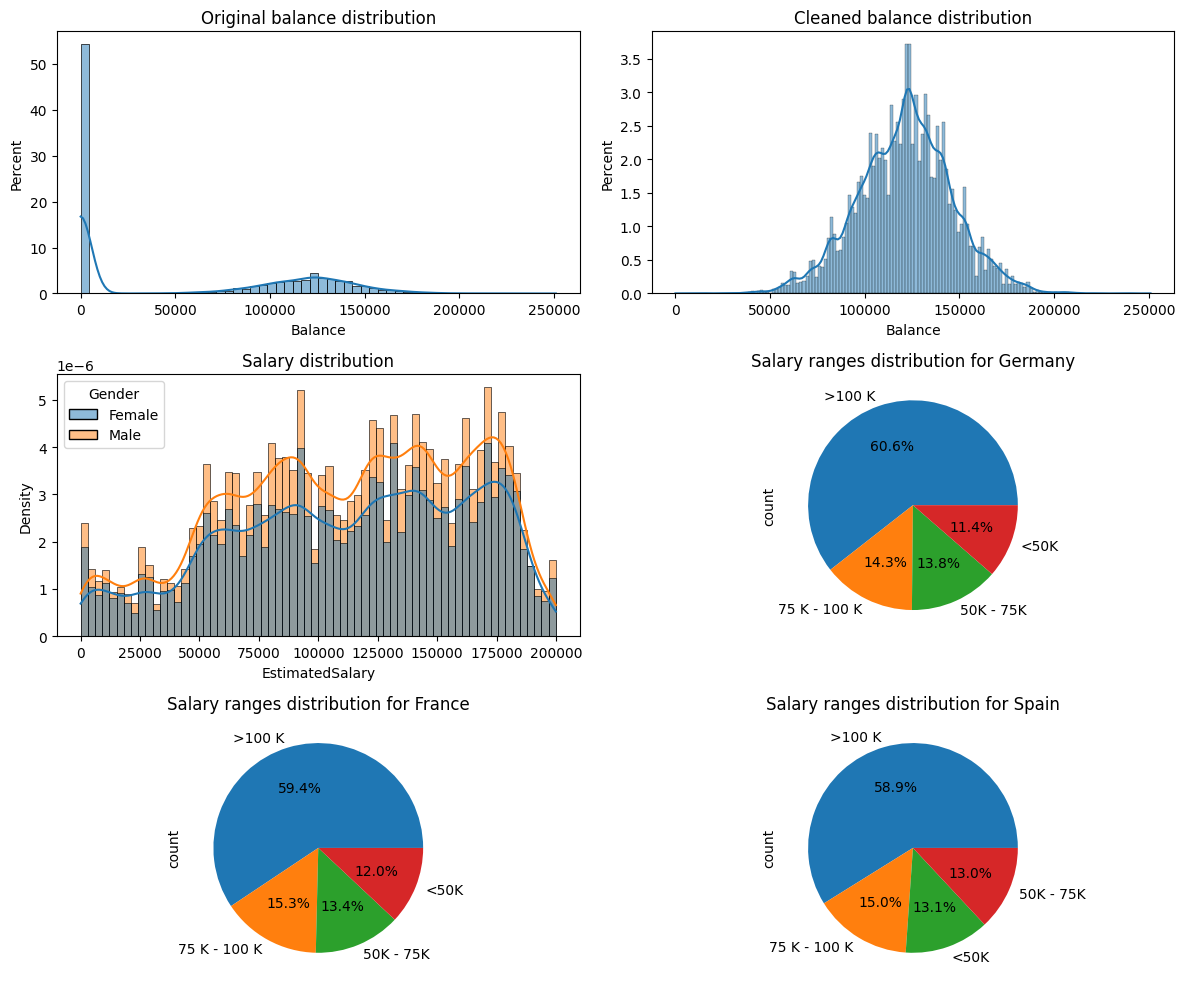

In [16]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])


sns.histplot(data=train, x='Balance', ax=ax1, kde=True, stat = 'percent')
ax1.set_title('Original balance distribution')

sns.histplot(data=train[train.Balance != 0], x='Balance', ax=ax2, kde=True, stat = 'percent')
ax2.set_title('Cleaned balance distribution')

sns.histplot(data=train, x='EstimatedSalary', hue='Gender', ax=ax3, kde=True, stat = 'density')
ax3.set_title('Salary distribution')


(train[train['Geography']=='Germany']['Salary_ranges'].value_counts() * 100 / len(train)).plot.pie(autopct='%1.1f%%', ax = ax4)
ax4.set_title('Salary ranges distribution for Germany')

(train[train['Geography']=='France']['Salary_ranges'].value_counts() * 100 / len(train)).plot.pie(autopct='%1.1f%%', ax = ax5)
ax5.set_title('Salary ranges distribution for France')

(train[train['Geography']=='Spain']['Salary_ranges'].value_counts() * 100 / len(train)).plot.pie(autopct='%1.1f%%', ax = ax6)
ax6.set_title('Salary ranges distribution for Spain')


plt.tight_layout()
plt.show()

### The remaining variables such as **Tenure**, **NumOfProducts**, **HasCrCard** and **IsActiveMember** can be also used as complementary information.



*   Tenure



Text(0.5, 1.0, 'Age ranges vs Tenure')

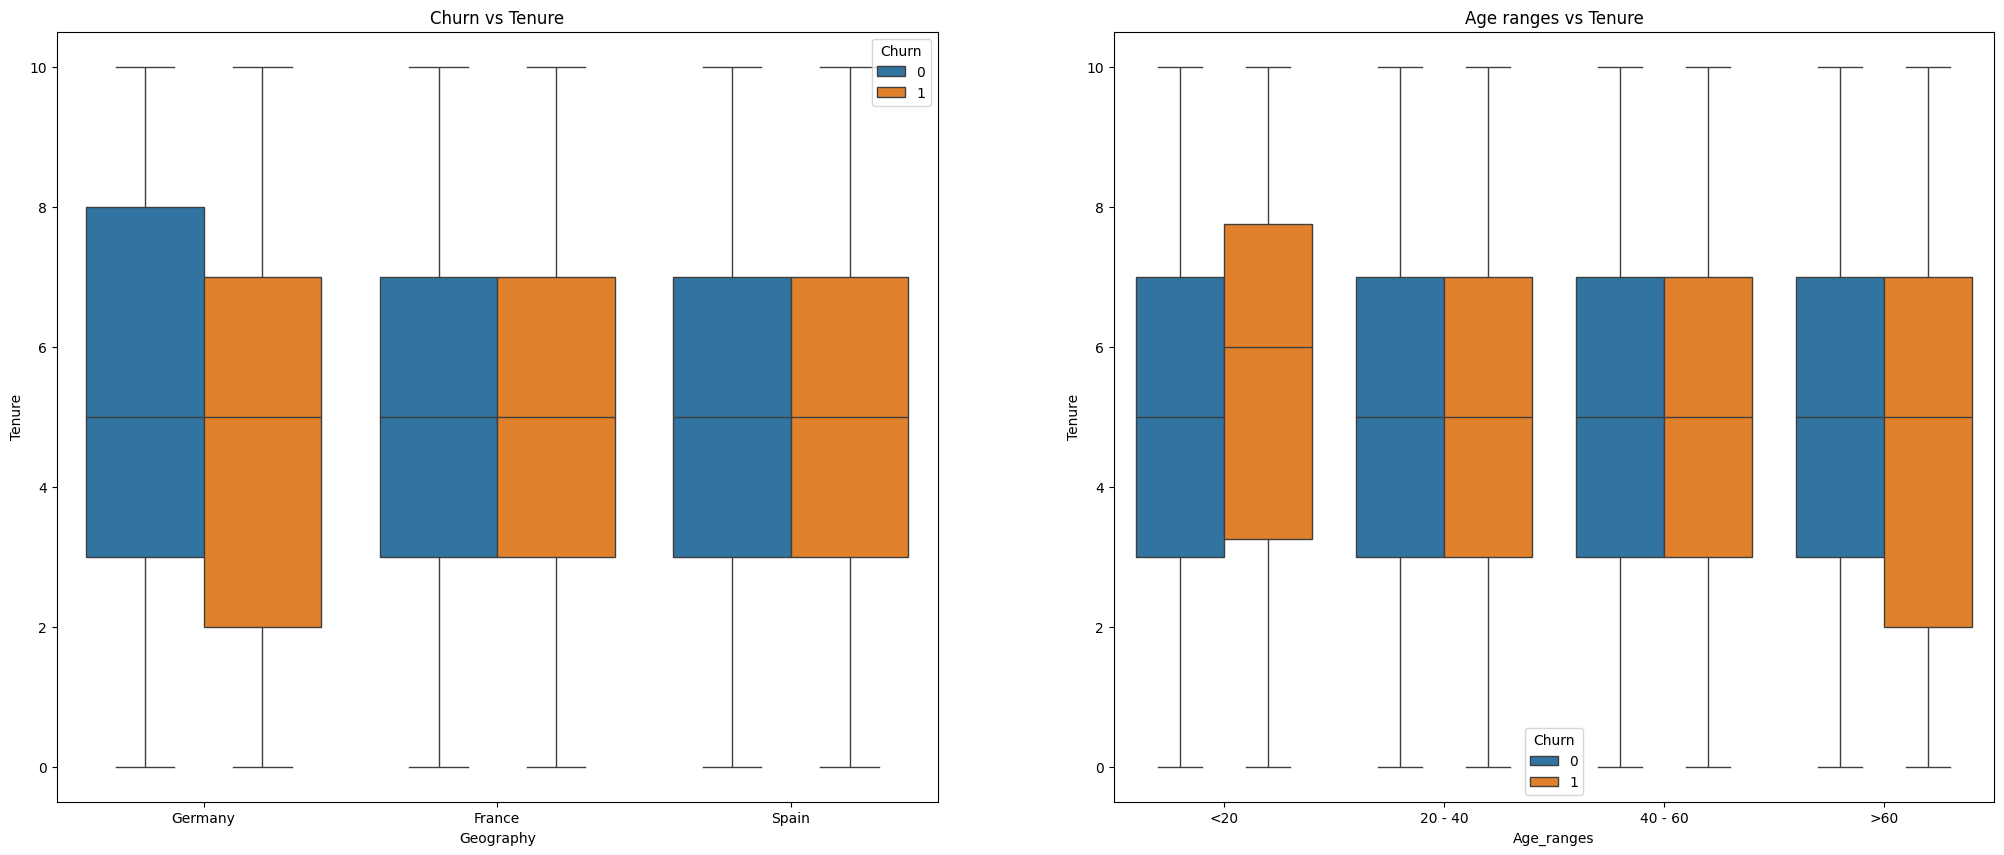

In [17]:
fig = plt.figure(figsize=(25, 10))

gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

sns.boxplot(data = train, x = 'Geography', y = 'Tenure', hue='Churn', ax = ax1)
ax1.set_title('Churn vs Tenure')



sns.boxplot(data = train, x = 'Age_ranges', y = 'Tenure', hue='Churn', ax = ax2)
ax2.set_title('Age ranges vs Tenure')


*   Number of products


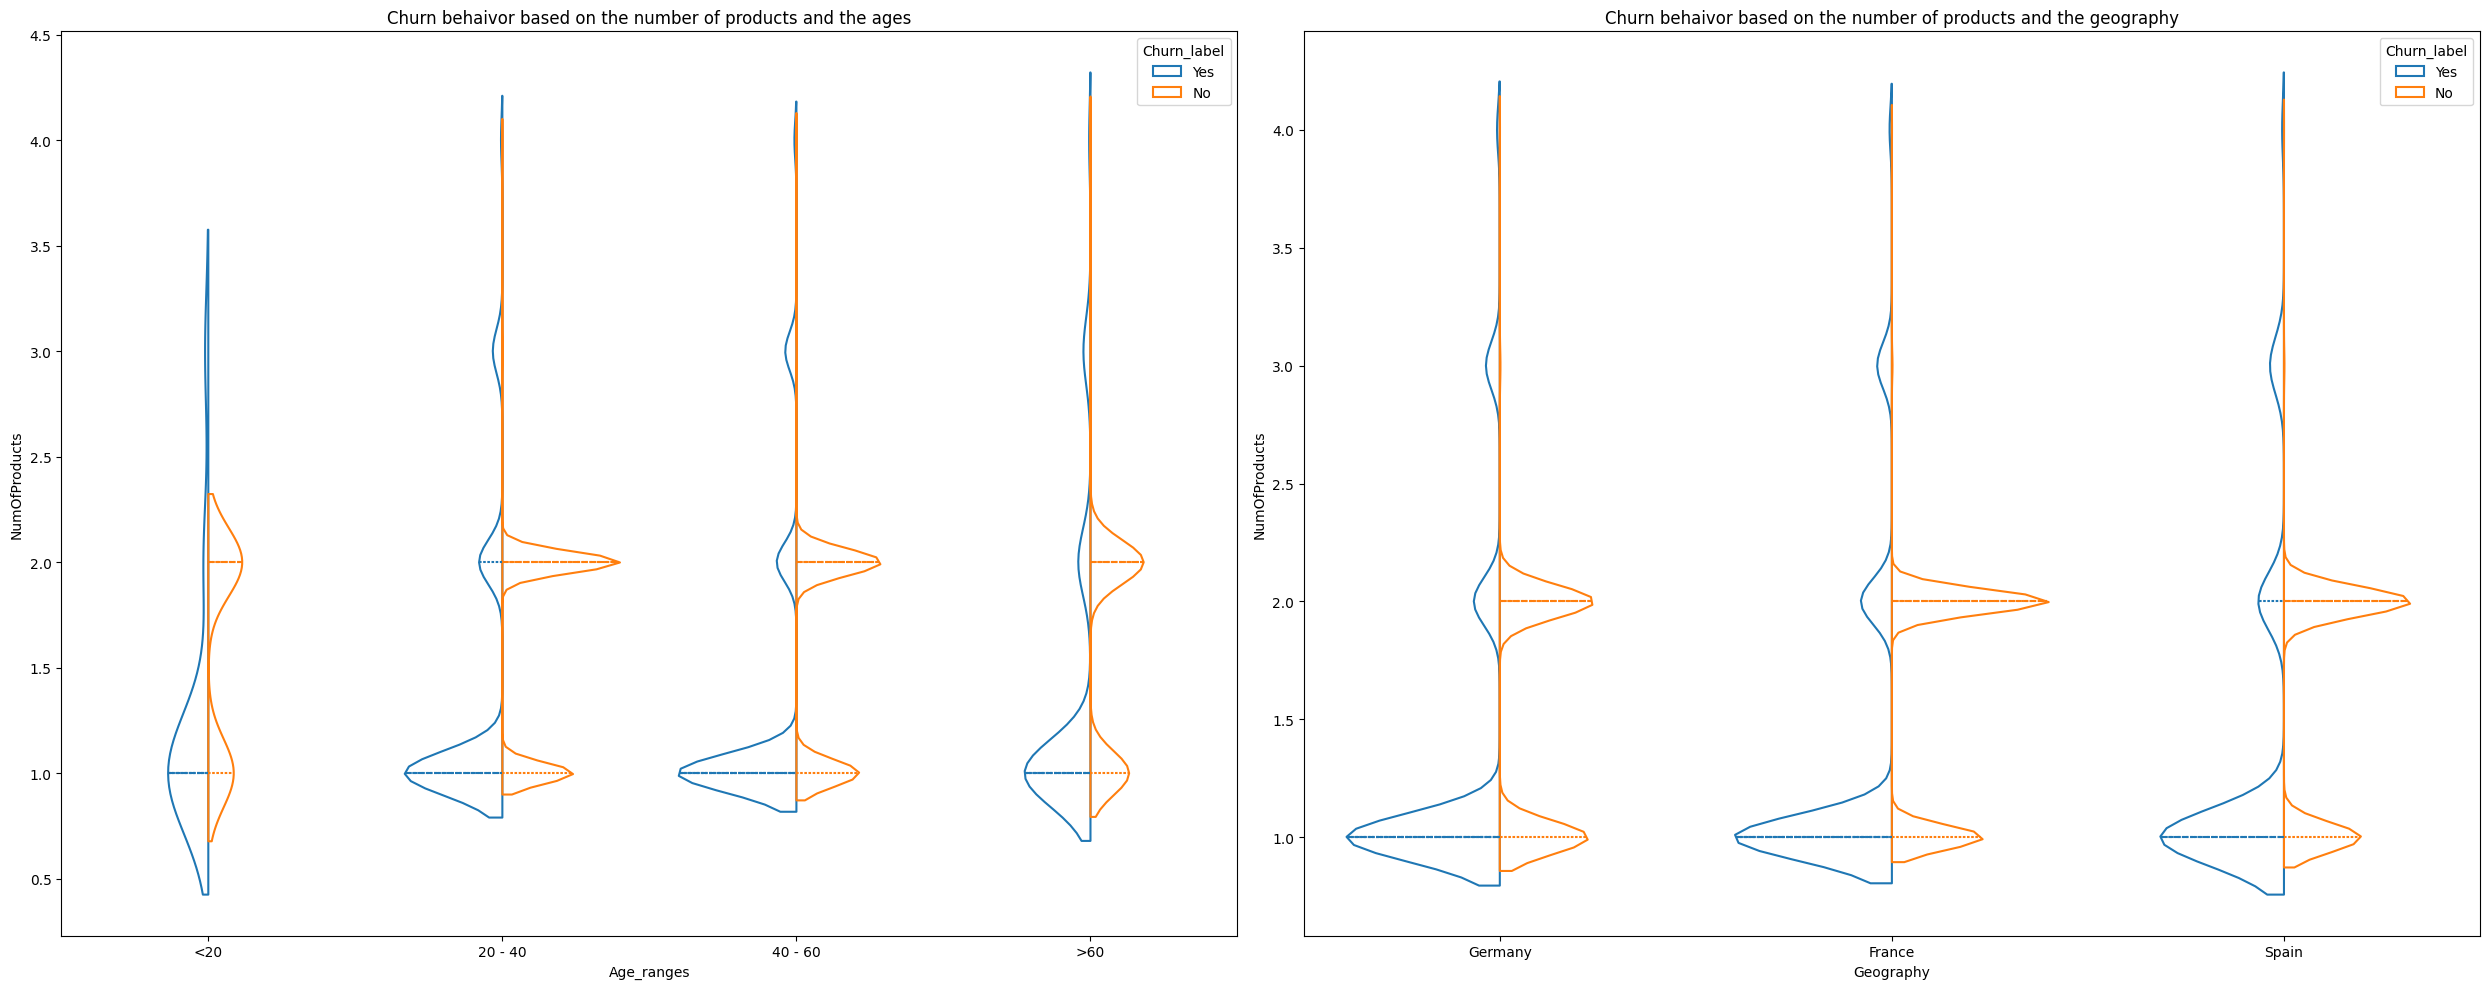

In [18]:
fig = plt.figure(figsize=(25, 10))

gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

sns.violinplot(data=train, x="Age_ranges", y="NumOfProducts", hue="Churn_label",
               split=True, inner="quart", fill=False, ax = ax1)
ax1.set_title('Churn behaivor based on the number of products and the ages')

sns.violinplot(data=train, x="Geography", y="NumOfProducts", hue="Churn_label",
               split=True, inner="quart", fill=False, ax = ax2)

#sns.histplot(data = train, x= 'NumOfProducts', hue = 'Churn', ax = ax2)
ax2.set_title('Churn behaivor based on the number of products and the geography')

plt.tight_layout()
plt.show()

Imbalances in the Chrun and Balance, for the case of balance most of the values are 0 probably there is no information and 0 is the default value, more information about the columns and how they are filled can be helpful.

## TRAINING

In [20]:

def statistical_information(y_true, y_predicted, classes):
    """Find basic statisitcal information such as F1-score, accuracy, sensitivity and specificity based on the predictions

    Args:
        y_true (list or numpy.array): Original labels
        y_predicted (list or numpy.array): Predictions done by the model
        classes (list): List of classes

    """
    # Calculate basic metrics like F1-score and accuracy
    f1 = f1_score(y_true, y_predicted, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_predicted, labels = classes)
    accuracy = accuracy_score(y_true, y_predicted)
    
    # Calculate the confusion matrix to find the sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_predicted).ravel()
    sensitivity = tp / (tp + fn) # recall
    specificity = tn / (tn + fp)
    
    # Print results in an specific format with 2 decimals
    print('***'*10)
    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Sensitivity or recall: {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print('***'*10)
    return accuracy, f1, sensitivity, specificity, conf_matrix

def metrics_plot(results):
    """Function that takes the results of a model training and creates a plot to show as bars this rsults

    Args:
        results (dict): Dictionary with model results and information
    """
    metrics_list = []
    # Add the results of each model to a list
    for key, values in results.items():
        metrics_list.append({
            'Model': key,
            'Accuracy': values['accuracy'],
            'F1 Score': values['f1'],
            'Sensitivity': values['sensitivity'],
            'Specificity': values['specificity']
        })
    # Transform it into a dataframe and unpivot the dataframe based on the models name
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
    # Plot a bar for each metric 
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=metrics_df_melted, x='Model', y='Score', hue='Metric')
    plt.title('Model Performance Metrics', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    # For every metric find their height and put that number above the bar if the height is different than 0
    for p in ax.patches:

        height = p.get_height()
        if height == 0:
            continue
        ax.annotate(f'{height:.2%}',xy=(p.get_x() + p.get_width() / 2, height),xytext=(0, 3),textcoords='offset points',ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


In [21]:
# Select the features as X and the target as y
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# Perform a split of the dataset, 30% for testing and the remaining for train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

# Scale the dataset, using the training to train the scaler and the fitting the testing samples
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled training set example:", X_train_scaled[:5])
print("Scaled testing set example:", X_test_scaled[:5])

Training set size: (103971, 13)
Testing set size: (44560, 13)
Scaled training set example: [[ 0.77470738  0.88699499  0.70601391 -0.88385486 -1.00808488  0.57079382
   1.00568118  1.43191528  0.86611044 -0.51274049 -0.53177525 -0.87975945
   0.87975945]
 [-0.85359586  0.21046348 -0.36470577 -0.88385486  0.81977987  0.57079382
  -0.99435091  1.3539502   0.86611044 -0.51274049 -0.53177525  1.13667435
  -1.13667435]
 [ 0.72460574  0.66148449 -1.07851889  1.37097276 -1.00808488  0.57079382
  -0.99435091  1.26036782 -1.15458717  1.95030432 -0.53177525  1.13667435
  -1.13667435]
 [ 0.33631805 -0.24055753  1.06292047  0.31042793 -1.00808488 -1.75194608
   1.00568118  0.38493337  0.86611044 -0.51274049 -0.53177525  1.13667435
  -1.13667435]
 [ 0.49914837 -0.80433379 -0.00779921  1.06418088 -1.00808488  0.57079382
  -0.99435091  1.08051148 -1.15458717  1.95030432 -0.53177525  1.13667435
  -1.13667435]]
Scaled testing set example: [[-0.79096881  0.54872924 -0.36470577 -0.88385486 -1.00808488  0.

## Unbalanced and no optimization (baseline)

The first set of experiments are done just taking into account the database unbalances and no hyper-parameter optimization, this can be consider the baseline. After that, the database needs to be balanced in terms of Churn. And the models can be optimize by doing a GridSearch to find the best set of hyperparameters. Multiple metrics such as accuracy, f1-score, recall and specificity are obtained.

In [22]:
# Define 3 basic models for the classification process
models_array = [('LR', LogisticRegression()),
                ('RF', RandomForestClassifier()),
                ('XGB', XGBClassifier())]

In [23]:
first_results = {}
for model_name, model in models_array:
    print(f'Model: {model_name}')
    # Add the models name as a key for the results
    first_results[model_name] = {}
    first_results[model_name]['model'] = model
    # Train the model just with the train set
    model.fit(X_train_scaled, y_train)
    # Predict the targets of the test set
    y_pred = model.predict(X_test_scaled)
    classes = [0, 1]
    # Find basic statistics and store it in the dictionary
    accuracy, f1, sensitivity, specificity, conf_matrix = statistical_information(y_test, y_pred, classes=classes)
    first_results[model_name]['accuracy'] = accuracy
    first_results[model_name]['f1'] = f1
    first_results[model_name]['sensitivity'] = sensitivity
    first_results[model_name]['specificity'] = specificity



Model: LR
******************************
Accuracy: 0.84
F1 Score: 0.82
Sensitivity or recall: 0.39
Specificity: 0.96
******************************
Model: RF
******************************
Accuracy: 0.86
F1 Score: 0.85
Sensitivity or recall: 0.54
Specificity: 0.95
******************************
Model: XGB
******************************
Accuracy: 0.87
F1 Score: 0.86
Sensitivity or recall: 0.56
Specificity: 0.95
******************************


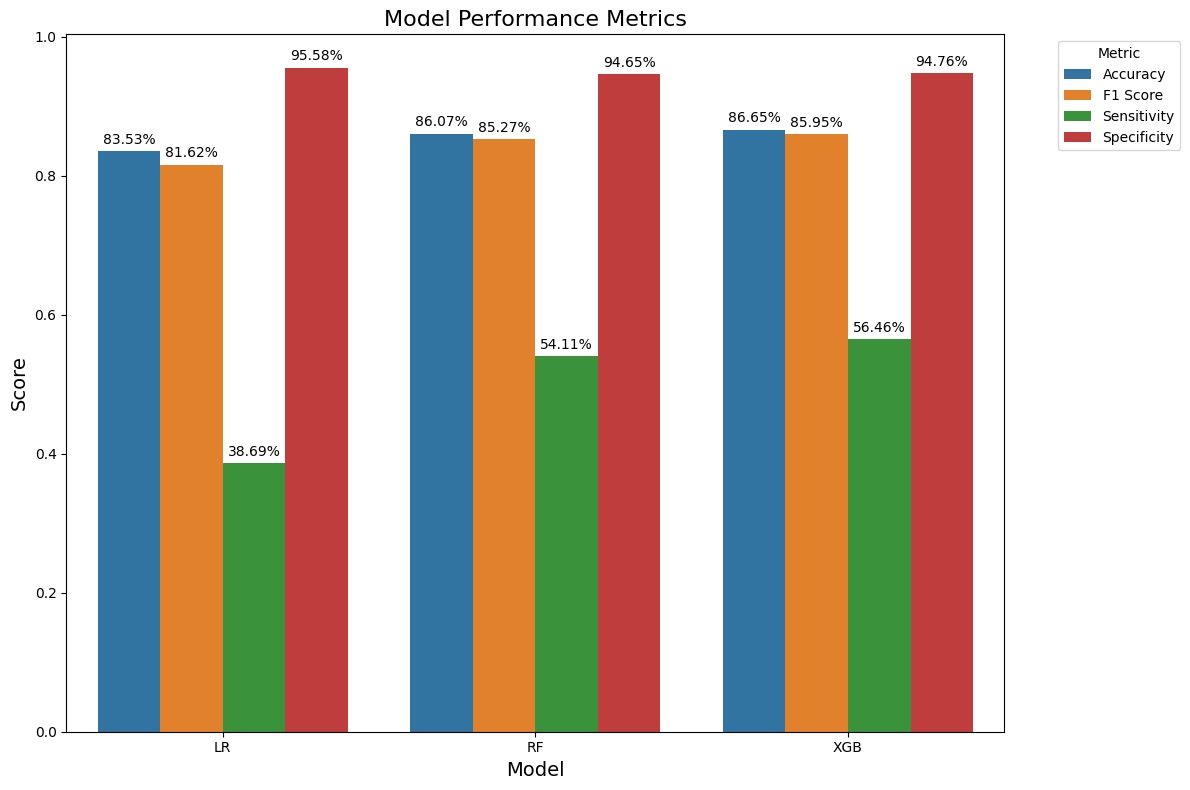

In [24]:
# Plot the results
metrics_plot(first_results)

## Balanced and no optimization

For the balancing process we need to take into account that our database has a 31.2% Churn rate, which means that the class of our interes has few samples, this can cause the model to achive bad results. To solve this, we can artificially create samples based on the samples we have in our database or we can drop samples to even out the database. Both methods are tested.

#### Oversampling

In [26]:
# Create a oversampler based on the Synthetic Minority Oversampling Technique
smote = SMOTE(random_state=42)
# Find a new train set that is more balanced thanks to the oversampler
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

In [27]:
# Repeat the same process as before now with the resampled set
oversampling_results = {}
first_results = {}
for model_name, model in models_array:
    print(f'Model: {model_name}')
    oversampling_results[model_name] = {}
    oversampling_results[model_name]['model'] = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    classes = [0, 1]

    accuracy, f1, sensitivity, specificity, conf_matrix = statistical_information(y_test, y_pred, classes=classes)
    oversampling_results[model_name]['accuracy'] = accuracy
    oversampling_results[model_name]['f1'] = f1
    oversampling_results[model_name]['sensitivity'] = sensitivity
    oversampling_results[model_name]['specificity'] = specificity


Model: LR
******************************
Accuracy: 0.76
F1 Score: 0.78
Sensitivity or recall: 0.73
Specificity: 0.77
******************************
Model: RF
******************************
Accuracy: 0.85
F1 Score: 0.85
Sensitivity or recall: 0.64
Specificity: 0.90
******************************
Model: XGB
******************************
Accuracy: 0.86
F1 Score: 0.86
Sensitivity or recall: 0.63
Specificity: 0.92
******************************


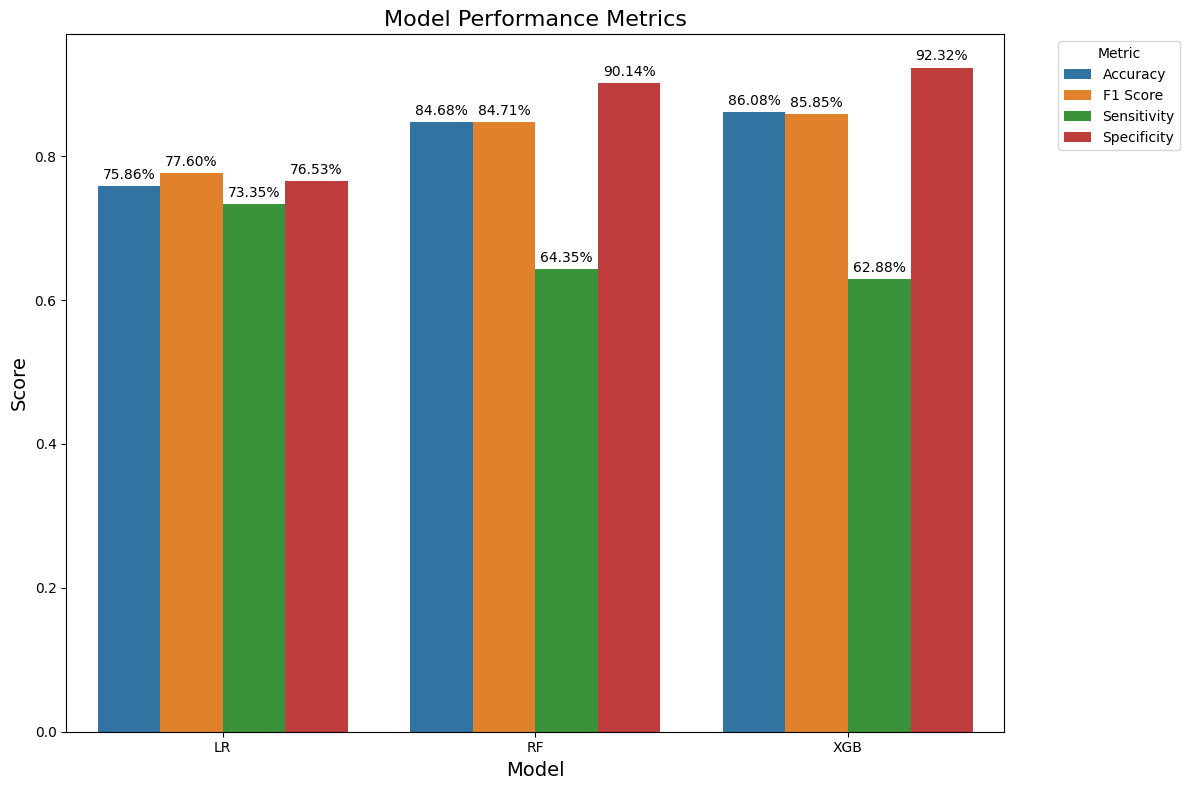

In [28]:
# Plot the new results
metrics_plot(oversampling_results)

#### Undersampling

In [30]:
# Undersample the dataset by removing random samples
rus = RandomUnderSampler(random_state=42)
# Create a new train set that has less samples
X_undersampled, y_undersampled = rus.fit_resample(X_train_scaled, y_train)

In [31]:
# Repeat the process with the undersample dataset
undersampling_results = {}
first_results = {}
for model_name, model in models_array:
    print(f'Model: {model_name}')
    undersampling_results[model_name] = {}
    undersampling_results[model_name]['model'] = model
    model.fit(X_undersampled, y_undersampled)
    y_pred = model.predict(X_test_scaled)
    classes = [0, 1]

    accuracy, f1, sensitivity, specificity, conf_matrix = statistical_information(y_test, y_pred, classes=classes)
    undersampling_results[model_name]['accuracy'] = accuracy
    undersampling_results[model_name]['f1'] = f1
    undersampling_results[model_name]['sensitivity'] = sensitivity
    undersampling_results[model_name]['specificity'] = specificity


Model: LR
******************************
Accuracy: 0.76
F1 Score: 0.77
Sensitivity or recall: 0.73
Specificity: 0.76
******************************
Model: RF
******************************
Accuracy: 0.80
F1 Score: 0.81
Sensitivity or recall: 0.79
Specificity: 0.80
******************************
Model: XGB
******************************
Accuracy: 0.81
F1 Score: 0.82
Sensitivity or recall: 0.79
Specificity: 0.81
******************************


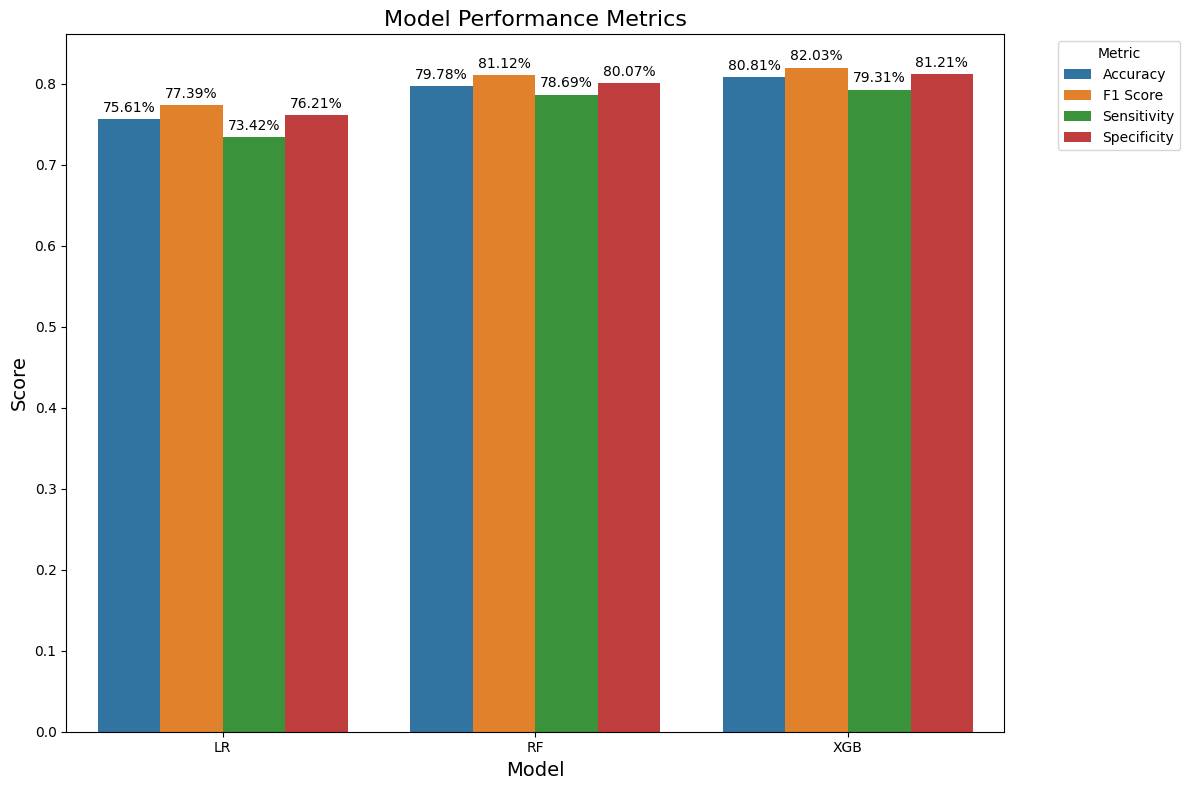

In [32]:
# Plot the results
metrics_plot(undersampling_results)

## Balance and optimization

### Hyperparameter optimization

In [33]:
# Define a new set of models, now with a grid of parameters to optimize
param_grids = {
    'LR': {
        'model': LogisticRegression(),
        'param_grid': {
            'C': [0.01, 0.1, 1, 10, 100]
        }
    },
    'RF': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    'XGB': {
        'model': XGBClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
}

In [34]:
best_models = {}
for model_name, model_params in param_grids.items():
    print(f"Optimizing {model_name}")
    # Define a grid search were all the parameters will be tested in the model to find the best combination
    grid_search = GridSearchCV(
        estimator=model_params['model'],
        param_grid=model_params['param_grid'],
        scoring=['accuracy', 'f1', 'recall', 'precision'],
        cv=5,
        n_jobs=-1,
        verbose=1,
        refit='accuracy'
    )
    # Fit the grid search with the undersample dataset
    grid_search.fit(X_undersampled, y_undersampled)
    # Store the information of the best model
    best_models[model_name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    }

# Print the results obtained
for model_name, result in best_models.items():
    print(f"\n{model_name}:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Score: {result['best_score']:.2f}")
    cv_results = pd.DataFrame(result['cv_results'])


Optimizing LR
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Optimizing RF
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Optimizing XGB
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/nestor/anaconda3/envs/test_env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/nestor/anaconda3/envs/test_env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' v


LR:
Best Parameters: {'C': 10}
Best Score: 0.75

RF:
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Best Score: 0.80

XGB:
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 50}
Best Score: 0.80


In [35]:
optimized_results = {}
# Instanciate a new model now with the best parameters found
for model_name, result in best_models.items():
  best_params = result['best_params']

  if model_name == 'LR':
      model_LR = LogisticRegression(**best_params)
  elif model_name == 'RF':
      model_RF = RandomForestClassifier(**best_params)
  elif model_name == 'XGB':
      model_XGB = XGBClassifier(**best_params)
# Create a new model array
models_array = [('LR', model_LR),
                ('RF', model_RF),
                ('XGB', model_XGB)]
# Train the new model with the best set of parameters fixed
for model_name, model in models_array:
    print(f'Model: {model_name}')
    optimized_results[model_name] = {}
    optimized_results[model_name]['model'] = model
    model.fit(X_undersampled, y_undersampled)
    y_pred = model.predict(X_test_scaled)
    classes = [0, 1]

    accuracy, f1, sensitivity, specificity, conf_matrix = statistical_information(y_test, y_pred, classes=classes)
    optimized_results[model_name]['accuracy'] = accuracy
    optimized_results[model_name]['f1'] = f1
    optimized_results[model_name]['sensitivity'] = sensitivity
    optimized_results[model_name]['specificity'] = specificity


Model: LR
******************************
Accuracy: 0.76
F1 Score: 0.77
Sensitivity or recall: 0.73
Specificity: 0.76
******************************
Model: RF


******************************
Accuracy: 0.81
F1 Score: 0.82
Sensitivity or recall: 0.80
Specificity: 0.81
******************************
Model: XGB
******************************
Accuracy: 0.81
F1 Score: 0.82
Sensitivity or recall: 0.79
Specificity: 0.82
******************************


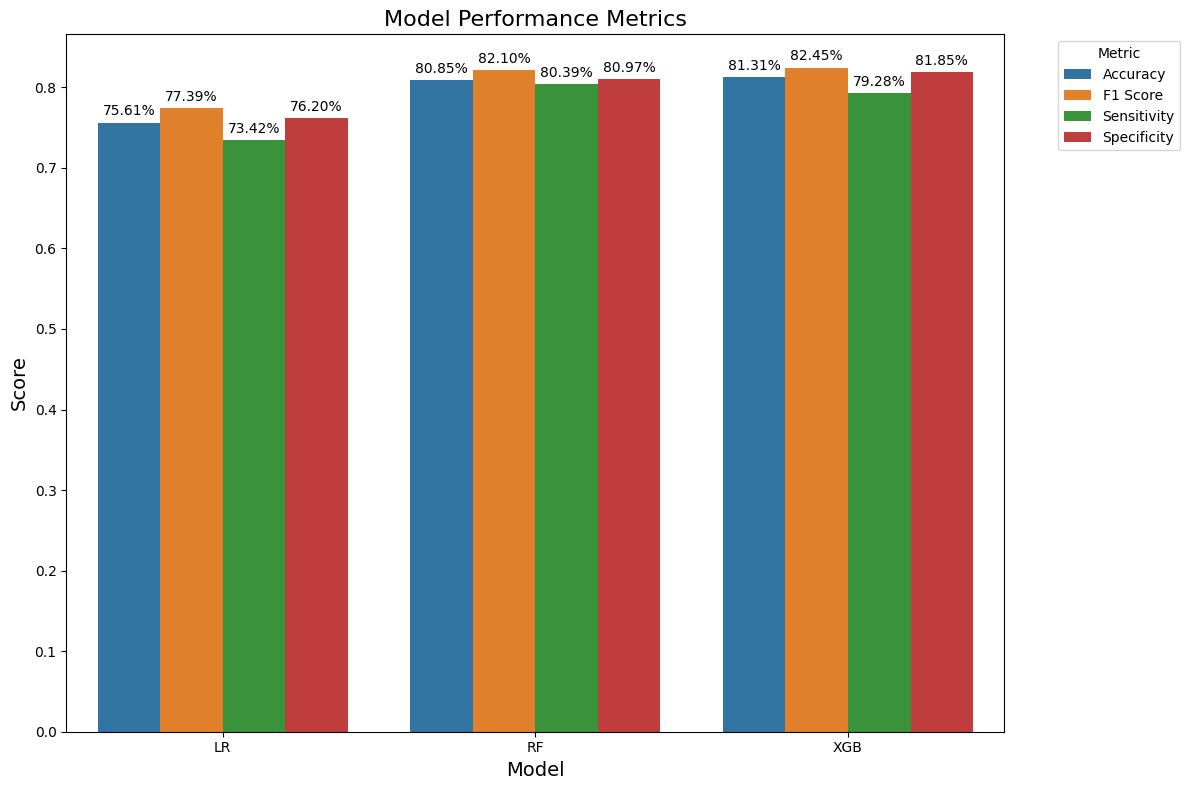

In [36]:
# Plot the results
metrics_plot(optimized_results)

## Results

The best model obtained was a Random Forest classifier with a max depth of 10 and a number of estimaators equal to 200, this random forest was trained with a undersample dataset (oversampling generated similar results so I decided to go with undersampling to avoid using a dataset that was augmented). The decision to select Random Forest was based on the **recall or sensitivity** metric. I choose this metric because we aim to find a model that is good detecting true positives or people that actually churn. Accuracy is not a good metric because this measures only the performance of the model, and an unbalance model can easly obtain high accuracies and low recall as showed in the unbalance training.

The best model is saved and can be load and use to test on unseen data. This process is also done to generate a prediction on the **inference.csv** file.

In [38]:
# Store the model as a pickle file
path_to_model = os.path.join(GENERAL_PATH,'best_model_churn.pkl')
with open(path_to_model, 'wb') as file:
    pickle.dump(model_RF, file)

In [39]:
# Load the model
with open(path_to_model, 'rb') as file:
    model = pickle.load(file)

In [40]:
# Transform the inference data as dummy and scale the data to find the prediction
inference_dummy = data_prepare(inference)
inference_scaled = scaler.transform(inference_dummy)
y_infered = model.predict(inference_scaled)
inference['Churn'] = y_infered
inference['Churn'].value_counts()

Churn
0    11215
1     5288
Name: count, dtype: int64

In [41]:
# Store the results in a csv file
inference.to_csv(os.path.join(GENERAL_PATH,'inference.csv'), index=False)

What would you do to improve the model in the future? Well, first I will like to capture more information about the subjects, having new features can be helpful to find better combinations and patterns. Using deep learning models can also be helpful, taking into account that there are high ammount of data.

How do you imagine what you just did in OOP? I imagine creating multiple classes: for example, one to handle the data, perform data augmentation or undersampling if necessary, scale the data, and generate the X and y variables. Another class would handle the model; within this class, we can create functions to train the model, make predictions, calculate metrics, and so on. Finally, all these classes would be initialized in a main file, where the methods defined within the classes will be used.

How do you deploy these models in production? So, I already did the first step, that was storing the model as a pickle file or another serializer. Then, we can create an API in python using things like FastAPI or Django, to create endpoints, were users will submit data in a format and this data will be predicted by the model. This can be left running locally or can be uploaded to AWS, Azure or any cloud based platform. 